In [1]:
# ========================================
# 1) Configuración, auditoría y parámetros
# ========================================

import os
from pathlib import Path
import glob
import json
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
from tqdm import tqdm

# --- Rutas (ajusta si lo necesitas) ---
OAS1_DIR = "DATA/OAS1_RAW"         # Raíz con carpetas OAS1_XXXX_MR1
OUT_DIR  = "DATA/OAS1_PROCESSED"   # PNGs por slice + inventario
os.makedirs(OUT_DIR, exist_ok=True)

# --- Parámetros de procesamiento ---
NUM_SLICES   = 20     # nº de cortes axiales equiespaciados (p.ej., 5, 10, 20)
EDGE_CROP    = 0.08   # recorte relativo en Z para evitar extremos (8% y 8%)
APPLY_CLAHE  = False  # por defecto OFF; se probará selectivamente si hace falta
CLAHE        = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# (Opcional) Re-muestreo con nilearn (afines), más correcto espacialmente que zoom
USE_NILEARN  = False
try:
    from nilearn.image import resample_to_img
    USE_NILEARN = True
except Exception:
    USE_NILEARN = False

print(f"Directorio OAS1_DIR: {OAS1_DIR}")
print(f"Directorio OUT_DIR : {OUT_DIR}")
print(f"n_slices={NUM_SLICES} | edge_crop={EDGE_CROP} | CLAHE={'ON' if APPLY_CLAHE else 'OFF'}")
print(f"nilearn disponible: {USE_NILEARN}")

# --- Auditoría simple de carpetas ---
mr_folders = sorted([p for p in Path(OAS1_DIR).glob("OAS1_*_MR1") if p.is_dir()])
print(f"Carpetas OAS1_*_MR1 encontradas: {len(mr_folders)}")
if len(mr_folders) > 0:
    print("Ejemplo:", mr_folders[0])


Directorio OAS1_DIR: DATA/OAS1_RAW
Directorio OUT_DIR : DATA/OAS1_PROCESSED
n_slices=20 | edge_crop=0.08 | CLAHE=OFF
nilearn disponible: True
Carpetas OAS1_*_MR1 encontradas: 416
Ejemplo: DATA\OAS1_RAW\OAS1_0001_MR1


In [2]:
# ========================================
# 2) Utilidades de imagen y E/S
# ========================================
import scipy.ndimage as ndi

def best_volume_path(mr_folder: Path) -> Path | None:
    """
    Selecciona el volumen 'mejor' para trabajar dentro de la carpeta OAS1_xxxx_MR1:
      1) PROCESSED/*.hdr (prioritario si existe)
      2) RAW/*mpr-*.hdr (Analyze)
    Devuelve ruta al .hdr o None si no hay.
    """
    processed_hdrs = sorted((mr_folder / "PROCESSED").glob("*.hdr"))
    if processed_hdrs:
        return processed_hdrs[0]
    raw_hdrs = sorted((mr_folder / "RAW").glob("*mpr-*.hdr"))
    if raw_hdrs:
        return raw_hdrs[0]
    return None


def _load_fsl_mask_any(mr_folder: Path) -> tuple[np.ndarray | None, nib.Nifti1Image | None, str]:
    """
    Busca en FSL_SEG cualquier archivo útil para máscara.
    Prioridad:
      1) *_fseg*.hdr   (segmentación tisular → binarizamos >0)
      2) *_mask*.hdr o *_brain*.hdr (máscara ya binaria)
    Devuelve: (mask_array OR None, mask_img_nifti OR None, mask_source_str)
    """
    seg_dir = mr_folder / "FSL_SEG"
    if not seg_dir.exists():
        return None, None, "none"

    # 1) Segmentaciones (frecuentes en tu caso)
    cands_fseg = sorted(seg_dir.glob("*fseg*.hdr"))
    # 2) Máscaras explícitas
    cands_mask = sorted(list(seg_dir.glob("*mask*.hdr")) + list(seg_dir.glob("*brain*.hdr")))

    try:
        if cands_fseg:
            mimg = nib.load(str(cands_fseg[0]))
            mdat = mimg.get_fdata()
            mask = (mdat > 0).astype(np.uint8)
            return mask, mimg, "fseg>0"

        if cands_mask:
            mimg = nib.load(str(cands_mask[0]))
            mdat = mimg.get_fdata()
            mask = (mdat > 0.5).astype(np.uint8)
            return mask, mimg, "mask/bin"
    except Exception:
        return None, None, "none"

    return None, None, "none"


def _resample_mask_to_shape(mask: np.ndarray, target_shape: tuple[int,int,int]) -> np.ndarray:
    """
    Re-muestrea máscara (array) a target_shape con vecino más cercano (order=0).
    Conserva binariedad 0/1.
    """
    if mask.shape == target_shape:
        return (mask > 0.5).astype(np.uint8)
    zx = target_shape[0] / mask.shape[0]
    zy = target_shape[1] / mask.shape[1]
    zz = target_shape[2] / mask.shape[2]
    resized = ndi.zoom(mask.astype(np.uint8), zoom=(zx, zy, zz), order=0)
    return (resized > 0.5).astype(np.uint8)


def _resample_mask_to_img(mask_img: nib.Nifti1Image, target_img: nib.Nifti1Image) -> np.ndarray:
    """
    Versión con nilearn.resample_to_img (si USE_NILEARN=True)
    - Usa interpolación 'nearest' para mantener máscara binaria.
    """
    mask_bin = (mask_img.get_fdata() > 0).astype(np.int16)
    mask_bin_img = nib.Nifti1Image(mask_bin, affine=mask_img.affine)
    mask_rs = resample_to_img(mask_bin_img, target_img, interpolation='nearest')
    return (mask_rs.get_fdata() > 0.5).astype(np.uint8)


def make_otsu_mask(volume_u8: np.ndarray) -> np.ndarray:
    """
    Fallback: máscara simple por Otsu sobre proyección media axial 2D → expandida a 3D.
    Se asume volume_u8 ∈ [0..255] uint8.
    """
    avg2d = volume_u8.mean(axis=2).astype(np.uint8)
    thr, _ = cv2.threshold(avg2d, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask2d = (avg2d > thr).astype(np.uint8)
    return np.repeat(mask2d[:, :, None], volume_u8.shape[2], axis=2)


def build_brain_mask(mr_folder: Path,
                     vol_hdr_path: Path,
                     vol_u8_for_otsu: np.ndarray,
                     vol_shape: tuple[int,int,int]) -> tuple[np.ndarray, str]:
    """
    Construye máscara cerebral:
      1) Intenta coger FSL_SEG (fseg>0 o mask/bin).
         - Si USE_NILEARN: remuestrea por affine → exacto.
         - Si no, remuestrea por forma (ndi.zoom order=0) → rápido y suficiente.
      2) Valida tamaño razonable (5%..95% voxels)
      3) Si falla: Otsu.
    Devuelve (mask, source_str) donde source_str ∈ {'fseg>0','mask/bin','otsu'}
    """
    m_arr, m_img, m_src = _load_fsl_mask_any(mr_folder)
    if m_arr is not None:
        try:
            if USE_NILEARN and m_img is not None:
                # Cargamos también el volumen como NIfTI para usar affine real
                vol_img = nib.load(str(vol_hdr_path))
                m_rs = _resample_mask_to_img(m_img, vol_img)
            else:
                m_rs = _resample_mask_to_shape(m_arr, vol_shape)
            frac = m_rs.mean()
            if 0.05 <= frac <= 0.95:
                return m_rs.astype(np.uint8), m_src
        except Exception:
            pass

    # Fallback robusto
    return make_otsu_mask(vol_u8_for_otsu), "otsu"


def normalize_volume_zscore(volume: np.ndarray, mask: np.ndarray | None = None) -> np.ndarray:
    """
    Z-score por volumen (recomendado) dentro de la máscara si existe.
    Devuelve uint8 [0..255] reescalado por percentiles (0.5, 99.5).
    """
    vol = volume.astype(np.float32)
    if mask is not None:
        m = mask > 0
        if m.sum() >= 50:
            mu = vol[m].mean()
            sd = vol[m].std() + 1e-8
            vol = (vol - mu) / sd
        else:
            vol = (vol - vol.mean()) / (vol.std() + 1e-8)
    else:
        vol = (vol - vol.mean()) / (vol.std() + 1e-8)

    vmin, vmax = np.percentile(vol, [0.5, 99.5])
    vol = np.clip((vol - vmin) / (vmax - vmin + 1e-8), 0, 1)
    return (vol * 255).astype(np.uint8)


def select_slices_indices(depth: int, num_slices: int, edge_crop: float = 0.08) -> list[int]:
    """
    Elige índices equiespaciados en Z evitando extremos (edge_crop).
    """
    z0 = int(depth * edge_crop)
    z1 = int(depth * (1 - edge_crop))
    z1 = max(z1, z0 + num_slices)
    idxs = np.linspace(z0, z1 - 1, num_slices).astype(int)
    idxs = np.unique(np.clip(idxs, 0, depth - 1)).tolist()
    return idxs


def save_slices_png(volume_u8: np.ndarray,
                    scan_id: str,
                    out_dir: str,
                    apply_clahe: bool = False,
                    num_slices: int = 20,
                    edge_crop: float = 0.08) -> list[str]:
    """
    Guarda slices axiales seleccionados, en RGB (para backbones preentrenados).
    Devuelve rutas guardadas.
    """
    saved = []
    H, W, D = volume_u8.shape
    idxs = select_slices_indices(D, num_slices, edge_crop)
    for i, z in enumerate(idxs):
        sl = volume_u8[:, :, z]
        if apply_clahe:
            sl = CLAHE.apply(sl)
        sl_rgb = cv2.cvtColor(sl, cv2.COLOR_GRAY2RGB)
        out_path = os.path.join(out_dir, f"{scan_id}_slice{i:02d}.png")
        cv2.imwrite(out_path, sl_rgb)
        saved.append(out_path)
    return saved


In [3]:
# ========================================
# 3) Bucle principal robusto:
#    - Carga 3D/4D y reduce a 3D
#    - Máscara FSL re-muestreada a geometría del volumen (si existe)
#    - Fallback a Otsu 3D cuando no hay máscara
#    - Z-score dentro de máscara y export a PNG (RGB)
#    - Inventario CSV
# ========================================
from nilearn.image import resample_to_img
from nilearn.masking import compute_background_mask

INVENTORY_CSV = os.path.join(OUT_DIR, "oasis1_slices_inventory.csv")

def squeeze_to_3d(arr: np.ndarray) -> np.ndarray:
    """
    Asegura salida 3D (H,W,D) desde 2D/3D/4D:
    - 2D → añade un eje D=1
    - 3D → tal cual
    - 4D → si última dim=1 → squeeze; si >1, usa el primer volumen
    """
    if arr.ndim == 2:
        return arr[..., None]
    if arr.ndim == 3:
        return arr
    if arr.ndim == 4:
        if arr.shape[-1] == 1:
            return np.squeeze(arr, axis=-1)
        else:
            return arr[..., 0]
    raise ValueError(f"Volumen con ndim no soportado: {arr.ndim}")

def load_volume_3d(vol_hdr_path: Path) -> tuple[np.ndarray, nib.spatialimages.SpatialImage]:
    """
    Carga un Analyze/NIfTI y devuelve (data_3d_float, img_ref).
    """
    target_img = nib.load(str(vol_hdr_path))   # AnalyzeImage/Nifti1Image
    vol = target_img.get_fdata()               # np.float64
    vol = squeeze_to_3d(vol).astype(np.float32)
    return vol, target_img

def find_fsl_mask_img(mr_folder: Path) -> nib.spatialimages.SpatialImage | None:
    """
    Busca una máscara plausible en FSL_SEG. Priorizamos ficheros *fseg*.hdr
    (p. ej.: mpr_n4_anon_111_t88_masked_gfc_fseg.hdr). Como respaldo,
    aceptamos *mask*.hdr o *brain*.hdr.
    """
    seg_dir = mr_folder / "FSL_SEG"
    if not seg_dir.exists():
        return None
    pats = ["*fseg*.hdr", "*mask*.hdr", "*brain*.hdr"]
    for pat in pats:
        cand = sorted(seg_dir.glob(pat))
        if cand:
            try:
                return nib.load(str(cand[0]))
            except Exception:
                continue
    return None

def get_mask_3d_aligned(mr_folder: Path, target_img) -> np.ndarray | None:
    """
    Devuelve una máscara binaria 3D alineada a target_img si es posible.
    Si no hay máscara FSL válida, devuelve None (usaremos Otsu).
    """
    mask_img = find_fsl_mask_img(mr_folder)
    if mask_img is None:
        return None

    # Re-muestrear a la geometría del volumen objetivo
    try:
        mask_rs = resample_to_img(
            mask_img, target_img, interpolation='nearest',
            # para evitar los warnings y usar el comportamiento futuro:
            force_resample=True
        )
        mask_data = mask_rs.get_fdata()
        mask_data = squeeze_to_3d(mask_data)
        # Binariza con umbral bajo por seguridad
        mask_bin = (mask_data > 0.5).astype(np.uint8)
        # Si está vacía, devuelvo None para forzar Otsu
        if mask_bin.sum() < 50:
            return None
        return mask_bin
    except Exception as e:
        # Si algo falla, volvemos a None (Otsu fallback)
        return None

def otsu_mask_3d_from_u8(vol_u8: np.ndarray) -> np.ndarray:
    """
    Máscara 3D simple por Otsu usando proyección media axial.
    Entrada: vol_u8 ∈ [0..255] uint8, forma (H,W,D).
    """
    avg2d = vol_u8.mean(axis=2).astype(np.uint8)
    thr, _ = cv2.threshold(avg2d, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask2d = (avg2d > thr).astype(np.uint8)
    mask3d = np.repeat(mask2d[:, :, None], vol_u8.shape[2], axis=2)
    return mask3d

def normalize_volume_zscore_u8(vol_float: np.ndarray, mask: np.ndarray | None) -> np.ndarray:
    """
    Z-score por volumen dentro de máscara (si existe).
    Devuelve uint8 reescalado a [0..255] con recorte de percentiles para robustez.
    """
    v = vol_float.astype(np.float32)
    if mask is not None and mask.shape == v.shape and mask.sum() >= 50:
        m = mask.astype(bool)
        mu, sd = v[m].mean(), v[m].std() + 1e-8
        v = (v - mu) / sd
    else:
        mu, sd = v.mean(), v.std() + 1e-8
        v = (v - mu) / sd

    # Stretch robusto a [0..255]
    lo, hi = np.percentile(v, [0.5, 99.5])
    v = np.clip((v - lo) / (hi - lo + 1e-8), 0, 1)
    return (v * 255).astype(np.uint8)

def save_slices_from_volume(vol_u8: np.ndarray, scan_id: str, out_dir: str,
                            num_slices: int, edge_crop: float, apply_clahe: bool) -> list[str]:
    """
    Guarda 'num_slices' cortes axiales equiespaciados (evitando extremos).
    """
    saved = []
    H, W, D = vol_u8.shape  # aquí ya debe ser 3D
    idxs = select_slices_indices(D, num_slices, edge_crop)
    for i, z in enumerate(idxs):
        sl = vol_u8[:, :, z]
        if apply_clahe:
            sl = CLAHE.apply(sl)
        sl_rgb = cv2.cvtColor(sl, cv2.COLOR_GRAY2RGB)
        out_path = os.path.join(out_dir, f"{scan_id}_slice{i:02d}.png")
        cv2.imwrite(out_path, sl_rgb)
        saved.append(out_path)
    return saved

# ------------------ PROCESADO PRINCIPAL ------------------
rows = []
mr_folders = sorted([p for p in Path(OAS1_DIR).glob("OAS1_*_MR1") if p.is_dir()])
print(f"Carpetas OASIS-1 encontradas: {len(mr_folders)}")

n_ok, n_fail = 0, 0

for folder in tqdm(mr_folders, desc="Procesando OASIS-1 MR1"):
    scan_id = folder.name  # p.ej., OAS1_0441_MR1
    vol_hdr = best_volume_path(folder)
    if vol_hdr is None:
        n_fail += 1
        print(f"[WARN] {scan_id}: no se encontró .hdr en PROCESSED/ ni RAW/")
        continue

    try:
        # 1) Carga volumen y referencia espacial
        vol_float, target_img = load_volume_3d(vol_hdr)   # (H,W,D) float32

        # 2) Intenta máscara de FSL (re-muestreada). Si falla, Otsu
        mask = get_mask_3d_aligned(folder, target_img)

        # Para Otsu necesitamos uint8 preliminar
        if mask is None:
            vmin, vmax = float(vol_float.min()), float(vol_float.max())
            if vmax > vmin:
                vol_u8_tmp = ((vol_float - vmin) / (vmax - vmin + 1e-8) * 255).astype(np.uint8)
            else:
                vol_u8_tmp = np.zeros_like(vol_float, dtype=np.uint8)
            mask = otsu_mask_3d_from_u8(vol_u8_tmp)

        # 3) Z-score dentro de máscara + reescalado a uint8
        vol_u8 = normalize_volume_zscore_u8(vol_float, mask)

        # 4) Guardar slices
        paths = save_slices_from_volume(
            vol_u8, scan_id, OUT_DIR,
            num_slices=NUM_SLICES, edge_crop=EDGE_CROP, apply_clahe=APPLY_CLAHE
        )

        # 5) Registrar inventario
        for pth in paths:
            rows.append({
                "scan_id": scan_id,
                "png_path": pth,
                "source_hdr": str(vol_hdr),
                "has_mask": 1 if mask is not None else 0,
            })
        n_ok += 1

    except Exception as e:
        n_fail += 1
        print(f"[WARN] {scan_id}: error procesando {vol_hdr.name} → {e}")

df_oasis1_images = pd.DataFrame(rows)
print(f"\n✔ Procesados OK: {n_ok} | ✖ Fallidos: {n_fail} | PNG totales: {len(rows)}")
print("Ejemplo inventario:")
display(df_oasis1_images.head(3))

# Guardar inventario CSV
df_oasis1_images.to_csv(INVENTORY_CSV, index=False)
print(f"Inventario guardado en: {INVENTORY_CSV}")



Carpetas OASIS-1 encontradas: 416


Procesando OASIS-1 MR1:   0%|          | 0/416 [00:00<?, ?it/s]C:\Users\PC\AppData\Local\Temp\ipykernel_29380\601746163.py:71: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mask_rs = resample_to_img(
Procesando OASIS-1 MR1:   0%|          | 1/416 [00:01<09:54,  1.43s/it]C:\Users\PC\AppData\Local\Temp\ipykernel_29380\601746163.py:71: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mask_rs = resample_to_img(
Procesando OASIS-1 MR1:   0%|          | 2/416 [00:03<11:32,  1.67s/it]C:\Users\PC\AppData\Local\Temp\ipykernel_29380\601746163.py:71: FutureWarning: From rel


✔ Procesados OK: 416 | ✖ Fallidos: 0 | PNG totales: 8320
Ejemplo inventario:


,scan_id,png_path,source_hdr,has_mask
0,OAS1_0001_MR1,DATA/OAS1_PROCESSED\OAS1_0001_MR1_slice00.png,DATA\OAS1_RAW\OAS1_0001_MR1\RAW\OAS1_0001_MR1_...,1
1,OAS1_0001_MR1,DATA/OAS1_PROCESSED\OAS1_0001_MR1_slice01.png,DATA\OAS1_RAW\OAS1_0001_MR1\RAW\OAS1_0001_MR1_...,1
2,OAS1_0001_MR1,DATA/OAS1_PROCESSED\OAS1_0001_MR1_slice02.png,DATA\OAS1_RAW\OAS1_0001_MR1\RAW\OAS1_0001_MR1_...,1


Inventario guardado en: DATA/OAS1_PROCESSED\oasis1_slices_inventory.csv


In [4]:
# ========================================
# 4) Enlazar PNGs con labels clínicos (OASIS-1) y crear splits
# ========================================
# Objetivo:
# - Tomar el inventario de PNGs (sección 3) y unirlo con los labels clínicos de OASIS-1.
# - Armonizar IDs (difieren en formato: OAS1_1 vs OAS1_0001 vs OAS1_0001_MR1).
# - Derivar el target binario desde CDR (0 = sano, >0 = demencia).
# - Dividir por paciente (60/20/20) en train/val/test evitando fugas.
# - Guardar CSVs con rutas y etiquetas de cada split.

import re
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

# ----------------------------------------
# 4.0 Parámetros de esta sección
# ----------------------------------------
# Ruta al inventario generado en la Sección 3
INV_PATH = Path(OUT_DIR) / "oasis1_slices_inventory.csv"

# Ruta al fichero clínico de OASIS-1 (ajústala a tu fichero real)
# Debe contener, como mínimo, las columnas 'ID' (o similar) y 'CDR'.
OAS1_CLINIC_PATH = "DATA/oasis_cross-sectional-5708aa0a98d82080.xlsx"  

# Ratios de validación y test (el resto es train)
VAL_SIZE  = 0.20
TEST_SIZE = 0.20
SEED      = 42

# Directorio de salida para los CSVs de splits
SPLIT_OUT_DIR = Path(OUT_DIR)
SPLIT_OUT_DIR.mkdir(parents=True, exist_ok=True)

# ----------------------------------------
# 4.1 Cargar inventario de PNGs
# ----------------------------------------
assert Path(INV_PATH).exists(), f"No se encontró inventario en {INV_PATH}. Ejecuta la Sección 3 primero."
df_inv = pd.read_csv(INV_PATH)

# Asegurar columnas esperadas
needed_cols = {"scan_id", "png_path", "source_hdr", "has_mask"}
missing = needed_cols - set(df_inv.columns)
assert not missing, f"Faltan columnas en el inventario: {missing}"

print("Inventario cargado:", df_inv.shape)
print(df_inv.head(3))



Inventario cargado: (8320, 4)
         scan_id                                       png_path  \
0  OAS1_0001_MR1  DATA/OAS1_PROCESSED\OAS1_0001_MR1_slice00.png   
1  OAS1_0001_MR1  DATA/OAS1_PROCESSED\OAS1_0001_MR1_slice01.png   
2  OAS1_0001_MR1  DATA/OAS1_PROCESSED\OAS1_0001_MR1_slice02.png   

                                          source_hdr  has_mask  
0  DATA\OAS1_RAW\OAS1_0001_MR1\RAW\OAS1_0001_MR1_...         1  
1  DATA\OAS1_RAW\OAS1_0001_MR1\RAW\OAS1_0001_MR1_...         1  
2  DATA\OAS1_RAW\OAS1_0001_MR1\RAW\OAS1_0001_MR1_...         1  


In [5]:
# ----------------------------------------
# 4.2 Utilidad para ID canónico (OAS1_####)
# ----------------------------------------
def canonize_oas1_id(x: str) -> str | float:
    """
    Convierte cualquier variante a 'OAS1_####':
      - 'OAS1_1' -> 'OAS1_0001'
      - 'OAS1_0001' -> 'OAS1_0001'
      - '1' (int/str) -> 'OAS1_0001'
      - 'OAS1_0001_MR1' -> 'OAS1_0001'
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip().upper()
    # patrón con prefijo OAS1_
    m = re.match(r'^(OAS1)_(\d{1,4})', s)
    if m:
        num = int(m.group(2))
        return f"OAS1_{num:04d}"
    # sólo dígitos
    m2 = re.search(r'(\d{1,4})', s)
    if m2:
        num = int(m2.group(1))
        return f"OAS1_{num:04d}"
    return s  # fallback

# Desde el inventario, derivar patient_id canónico a partir del scan_id (p.ej. 'OAS1_0001_MR1' -> 'OAS1_0001')
df_inv["patient_id_raw"]   = df_inv["scan_id"].str.replace(r"_MR\d+$", "", regex=True)
df_inv["patient_id_canon"] = df_inv["patient_id_raw"].apply(canonize_oas1_id)

print("\nEjemplos inventario (ID → canónico):")
print(df_inv[["scan_id", "patient_id_raw", "patient_id_canon"]].head(3))


Ejemplos inventario (ID → canónico):
         scan_id patient_id_raw patient_id_canon
0  OAS1_0001_MR1      OAS1_0001        OAS1_0001
1  OAS1_0001_MR1      OAS1_0001        OAS1_0001
2  OAS1_0001_MR1      OAS1_0001        OAS1_0001


In [6]:
# ----------------------------------------
# 4.3 Cargar clínico OASIS-1 y derivar target desde CDR
# ----------------------------------------
assert Path(OAS1_CLINIC_PATH).exists(), f"No se encontró el fichero clínico en {OAS1_CLINIC_PATH}"

df_o1_raw = pd.read_excel(OAS1_CLINIC_PATH)

print("\nClínico OASIS-1 columnas:", df_o1_raw.columns.to_list())


Clínico OASIS-1 columnas: ['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']


In [7]:
# Detectar columna de ID (flexible)
col_id = None
for c in df_o1_raw.columns:
    cu = str(c).strip().upper()
    if cu in ["ID", "SUBJECT ID", "SUBJECT_ID", "OASISID", "OASIS_ID"]:
        col_id = c; break
if col_id is None:
    # fallback: usa la primera columna si no se detecta
    col_id = df_o1_raw.columns[0]

# Detectar CDR
col_cdr = None
for c in df_o1_raw.columns:
    if str(c).strip().upper() == "CDR":
        col_cdr = c; break
assert col_cdr is not None, "No se encontró la columna 'CDR' en el clínico OASIS-1."

# Extraer y normalizar lo necesario
df_o1 = pd.DataFrame({
    "patient_id_raw": df_o1_raw[col_id].astype(str).str.strip(),
    "cdr": pd.to_numeric(df_o1_raw[col_cdr], errors="coerce")
}).dropna(subset=["cdr"])

df_o1["patient_id_canon"] = df_o1["patient_id_raw"].apply(canonize_oas1_id)
df_o1["target"] = (df_o1["cdr"] > 0.0).astype(int)
df_o1 = df_o1[["patient_id_canon", "target"]].drop_duplicates()

print("\nClínico OASIS-1 (procesado) — ejemplo:")
print(df_o1.head(3))


Clínico OASIS-1 (procesado) — ejemplo:
  patient_id_canon  target
0        OAS1_0001       0
1        OAS1_0002       0
2        OAS1_0003       1


In [8]:
# ----------------------------------------
# 4.4 Merge inventario + clínico (por ID canónico) y diagnóstico
# ----------------------------------------
df_imgs = df_inv.merge(df_o1, on="patient_id_canon", how="inner")

print(f"\nPNG con label unidos: {len(df_imgs)} / {len(df_inv)}")
if len(df_imgs) == 0:
    # Diagnóstico: comparar universos de pacientes
    pats_inv = set(df_inv["patient_id_canon"].unique())
    pats_cli = set(df_o1["patient_id_canon"].unique())
    inter = pats_inv & pats_cli
    print(f"Pacientes inventario: {len(pats_inv)} | clínico: {len(pats_cli)} | intersección: {len(inter)}")
    print("Ejemplos inventario-only:", list(pats_inv - pats_cli)[:5])
    print("Ejemplos clínico-only:", list(pats_cli - pats_inv)[:5])
else:
    # Balance por clase (contando PNGs)
    bal_png = df_imgs.groupby("target")["png_path"].count().rename("n")
    print("\nDistribución por clase (por PNG):")
    print(bal_png)

    # Balance por paciente
    pats_lab = df_imgs[["patient_id_canon", "target"]].drop_duplicates()
    bal_pat = pats_lab["target"].value_counts().rename("n")
    print("\nDistribución por clase (por PACIENTE):")
    print(bal_pat)



PNG con label unidos: 4700 / 8320

Distribución por clase (por PNG):
target
0    2700
1    2000
Name: n, dtype: int64

Distribución por clase (por PACIENTE):
target
0    135
1    100
Name: n, dtype: int64


In [10]:
# ----------------------------------------
# 4.5 Split por PACIENTE (train/val/test 60/20/20)
# ----------------------------------------
if len(df_imgs) > 0:
    df_imgs = df_imgs.rename(columns={"patient_id_canon": "patient_id"})  # nombre homogéneo
    # diccionario de label por paciente
    patient_labels = df_imgs[["patient_id", "target"]].drop_duplicates().set_index("patient_id")["target"].to_dict()
    patients = np.array(list(patient_labels.keys()))
    labels   = np.array([patient_labels[p] for p in patients])

    # Train vs (Val+Test)
    p_train, p_rest, y_train, y_rest = train_test_split(
        patients, labels,
        test_size=(VAL_SIZE + TEST_SIZE),
        stratify=labels,
        random_state=SEED
    )
    # Val vs Test (mantenemos proporciones)
    val_ratio = VAL_SIZE / (VAL_SIZE + TEST_SIZE)
    p_val, p_test, y_val, y_test = train_test_split(
        p_rest, y_rest,
        test_size=(1 - val_ratio),
        stratify=y_rest,
        random_state=SEED
    )

    def subset_by_patients(df, plist):
        return df[df["patient_id"].isin(plist)].reset_index(drop=True)

    df_train = subset_by_patients(df_imgs, p_train)
    df_val   = subset_by_patients(df_imgs, p_val)
    df_test  = subset_by_patients(df_imgs, p_test)

    def report_subset(df, name):
        u_pat = df["patient_id"].nunique()
        bal_png = df.groupby("target")["png_path"].count().rename("n")
        print(f"{name}: PNG={len(df):5d} | pacientes={u_pat:4d}\n{bal_png}\n")

    print("\n=== Resumen splits por PACIENTE ===")
    report_subset(df_train, "Train")
    report_subset(df_val,   "Val")
    report_subset(df_test,  "Test")

    # ----------------------------------------
    # 4.6 Guardar CSVs de splits (para usar en el DataLoader después)
    # ----------------------------------------
    cols_to_save = ["png_path", "target", "patient_id", "scan_id", "source_hdr", "has_mask"]
    df_train[cols_to_save].to_csv(SPLIT_OUT_DIR / "oas1_train.csv", index=False)
    df_val[cols_to_save].to_csv(SPLIT_OUT_DIR / "oas1_val.csv",   index=False)
    df_test[cols_to_save].to_csv(SPLIT_OUT_DIR / "oas1_test.csv", index=False)

    print("CSV de splits guardados en:")
    print(f"  - {SPLIT_OUT_DIR / 'oas1_train.csv'}")
    print(f"  - {SPLIT_OUT_DIR / 'oas1_val.csv'}")
    print(f"  - {SPLIT_OUT_DIR / 'oas1_test.csv'}")
else:
    print("\n⚠️ No se puede hacer split: el merge no produjo filas. Revisa OAS1_CLINIC_PATH y la detección de columnas ID/CDR.")


=== Resumen splits por PACIENTE ===
Train: PNG= 2820 | pacientes= 141
target
0    1620
1    1200
Name: n, dtype: int64

Val: PNG=  940 | pacientes=  47
target
0    540
1    400
Name: n, dtype: int64

Test: PNG=  940 | pacientes=  47
target
0    540
1    400
Name: n, dtype: int64

CSV de splits guardados en:
  - DATA\OAS1_PROCESSED\oas1_train.csv
  - DATA\OAS1_PROCESSED\oas1_val.csv
  - DATA\OAS1_PROCESSED\oas1_test.csv


In [ ]:
# ======================================
# 🔎 SECCIÓN 4 — Unión de datos clínicos con imágenes
# ======================================
# 
# En esta sección hemos vinculado los datos de imagen procesados
# (slices en PNG obtenidos de los volúmenes originales de OASIS-1)
# con la información clínica tabulada del dataset.
#
# ➡ Proceso seguido:
# 1. Cargamos el inventario de imágenes generado en la Sección 3 
#    (8.320 slices en total a partir de 416 sujetos).
#
# 2. Estandarizamos los identificadores de paciente (ej. "OAS1_0001_MR1")
#    para emparejarlos correctamente con los IDs clínicos de OASIS-1.
#
# 3. Seleccionamos como variable objetivo (target) el valor de CDR:
#    - target = 0 → CDR = 0 (cognición normal)
#    - target = 1 → CDR ≥ 0.5 (deterioro cognitivo/demencia)
#
# 4. Realizamos el merge entre inventario de imágenes y tabla clínica.
#    No todos los sujetos tienen datos completos, por lo que de los
#    8.320 PNGs iniciales nos quedamos con 4.700 PNGs que sí tienen
#    información clínica asociada y target definido.
#
# 5. Exploramos la distribución de clases:
#    - Por imágenes: 2.700 controles vs 2.000 demencias
#    - Por pacientes: 135 controles vs 100 demencias
#    El dataset queda razonablemente balanceado.
#
# 6. Definimos splits para entrenamiento, validación y test a nivel 
#    de paciente (no de imagen), evitando fuga de datos entre grupos:
#    - Train: 2.820 PNGs (141 pacientes)
#    - Val:   940 PNGs  (47 pacientes)
#    - Test:  940 PNGs  (47 pacientes)
#
# 7. Guardamos los CSV correspondientes (oas1_train.csv, 
#    oas1_val.csv, oas1_test.csv), que contienen para cada slice:
#    - ruta del PNG
#    - ID de paciente
#    - target
#    - metadatos básicos
#
# ✅ Con esto tenemos un dataset preparado para ser utilizado en
#    PyTorch/TensorFlow, con splits claros y sin fuga de pacientes.
#
# El siguiente paso será crear DataLoaders que lean estos CSVs,
# carguen las imágenes en tensores y apliquen las transformaciones
# necesarias para el entrenamiento de un modelo CNN.


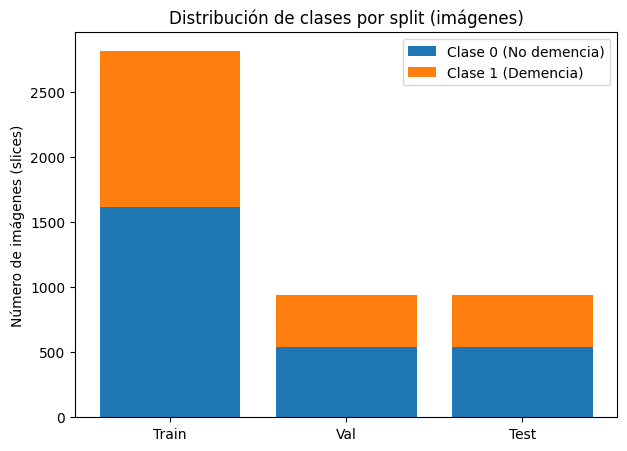

In [10]:
# Distribución por imágenes (por slice)

import matplotlib.pyplot as plt

# Datos por split (slices)
splits_slices = {
    "Train": {"0": 1620, "1": 1200},
    "Val":   {"0": 540,  "1": 400},
    "Test":  {"0": 540,  "1": 400},
}

# Preparar datos
splits = list(splits_slices.keys())
class0 = [splits_slices[s]["0"] for s in splits]
class1 = [splits_slices[s]["1"] for s in splits]

# Plot
plt.figure(figsize=(7,5))
plt.bar(splits, class0, label="Clase 0 (No demencia)", color="#1f77b4")
plt.bar(splits, class1, bottom=class0, label="Clase 1 (Demencia)", color="#ff7f0e")

plt.ylabel("Número de imágenes (slices)")
plt.title("Distribución de clases por split (imágenes)")
plt.legend()
plt.show()


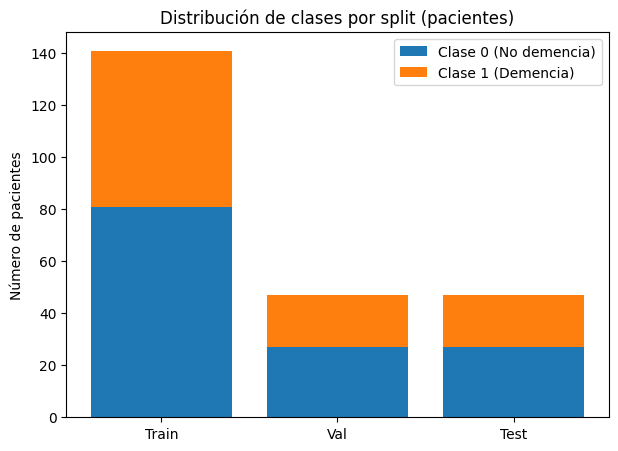

In [11]:
# Distrubución por pacientes

# Datos por split (pacientes)
splits_pacientes = {
    "Train": {"0": 81, "1": 60},   # 141 pacientes totales
    "Val":   {"0": 27, "1": 20},   # 47 pacientes
    "Test":  {"0": 27, "1": 20},   # 47 pacientes
}

# Preparar datos
splits = list(splits_pacientes.keys())
class0_p = [splits_pacientes[s]["0"] for s in splits]
class1_p = [splits_pacientes[s]["1"] for s in splits]

# Plot
plt.figure(figsize=(7,5))
plt.bar(splits, class0_p, label="Clase 0 (No demencia)", color="#1f77b4")
plt.bar(splits, class1_p, bottom=class0_p, label="Clase 1 (Demencia)", color="#ff7f0e")

plt.ylabel("Número de pacientes")
plt.title("Distribución de clases por split (pacientes)")
plt.legend()
plt.show()


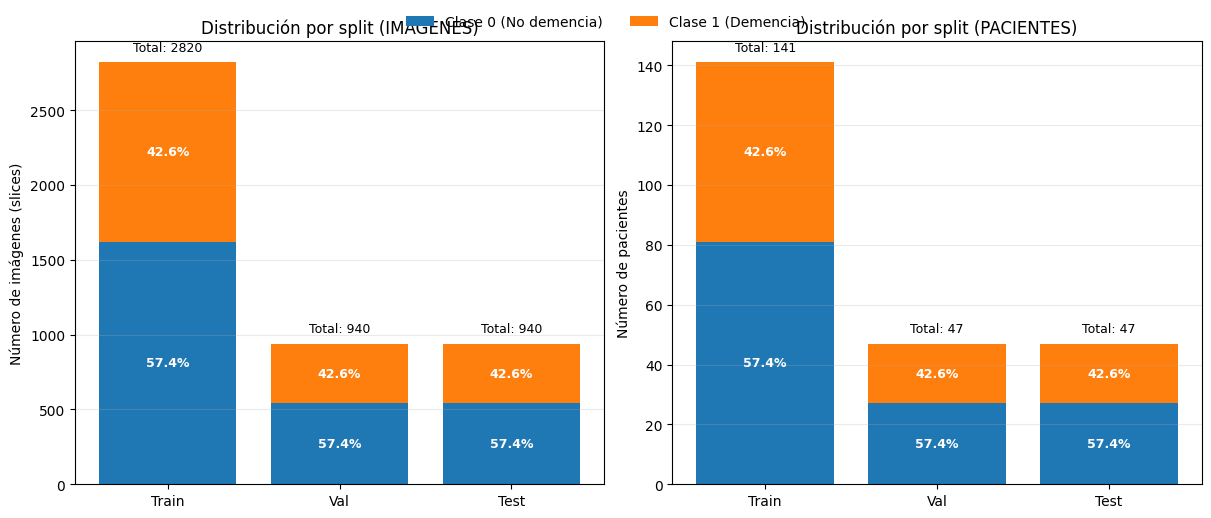

In [12]:
# Gráfico comparativo lado a lado (slices vs pacientes)

import matplotlib.pyplot as plt
import numpy as np

# ===== Datos (ajusta si cambian) =====
# Por imágenes (slices)
splits_slices = {
    "Train": {"0": 1620, "1": 1200},
    "Val":   {"0": 540,  "1": 400},
    "Test":  {"0": 540,  "1": 400},
}
# Por pacientes
splits_pacientes = {
    "Train": {"0": 81, "1": 60},   # 141 pacientes
    "Val":   {"0": 27, "1": 20},   # 47 pacientes
    "Test":  {"0": 27, "1": 20},   # 47 pacientes
}

# Colores consistentes
c0 = "#1f77b4"  # Clase 0 (No demencia)
c1 = "#ff7f0e"  # Clase 1 (Demencia)

def stacked_bar(ax, data_dict, ylabel, title):
    splits = list(data_dict.keys())
    class0 = np.array([data_dict[s]["0"] for s in splits])
    class1 = np.array([data_dict[s]["1"] for s in splits])
    totals = class0 + class1
    p1 = 100 * class1 / totals  # % demencia
    p0 = 100 * class0 / totals  # % no demencia

    # Barras
    ax.bar(splits, class0, label="Clase 0 (No demencia)", color=c0)
    ax.bar(splits, class1, bottom=class0, label="Clase 1 (Demencia)", color=c1)

    # Anotaciones: total arriba + % dentro
    for i, s in enumerate(splits):
        # total encima
        ax.text(i, totals[i] + totals.max()*0.02, f"Total: {totals[i]}", ha="center", va="bottom", fontsize=9)
        # porcentajes dentro de cada segmento (si hay altura suficiente)
        if class0[i] > 0:
            ax.text(i, class0[i]/2, f"{p0[i]:.1f}%", ha="center", va="center", color="white", fontsize=9, fontweight="bold")
        if class1[i] > 0:
            ax.text(i, class0[i] + class1[i]/2, f"{p1[i]:.1f}%", ha="center", va="center", color="white", fontsize=9, fontweight="bold")

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.25)

# ===== Figure comparativa =====
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

stacked_bar(
    axes[0],
    splits_slices,
    ylabel="Número de imágenes (slices)",
    title="Distribución por split (IMÁGENES)"
)

stacked_bar(
    axes[1],
    splits_pacientes,
    ylabel="Número de pacientes",
    title="Distribución por split (PACIENTES)"
)

# Leyenda única
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))

plt.show()



In [11]:
# ========================================
# 5) Dataset y DataLoaders (PyTorch)
#    - Lee los CSV de splits (train/val/test)
#    - Define transforms (augmentación en train)
#    - Construye Dataset/Loaders
#    - Opcional: WeightedRandomSampler para mitigar desbalance
# ========================================

import os
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T

# --- Rutas de los splits generados en la Sección 4 ---
TRAIN_CSV = os.path.join(OUT_DIR, "oas1_train.csv")
VAL_CSV   = os.path.join(OUT_DIR, "oas1_val.csv")
TEST_CSV  = os.path.join(OUT_DIR, "oas1_test.csv")

# --- Hiperparámetros de entrada/sistema ---
IMG_SIZE     = 224
BATCH_SIZE   = 32
NUM_WORKERS  = 4           # ajusta según tu CPU
PIN_MEMORY   = True
PERSISTENT   = True
AUG_TRAIN    = True        # activa/desactiva augmentación de entrenamiento
USE_SAMPLER  = True        # activa sampler ponderado por clase (slices)
SEED         = 42

# --- Dispositivo ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# --- Semillas para reproducibilidad ---
def set_seeds(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Modo determinista (ligera pérdida de rendimiento, pero más reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(SEED)


Device: cpu


In [12]:
# ----------------------------------------
# 5.1 Dataset a partir de PNG + CSV
# ----------------------------------------
class OASISMRIDatasetPNG(Dataset):
    """
    Dataset simple que:
      - Lee filas de un CSV con columnas: [png_path, target, scan_id, patient_id_canon]
      - Devuelve: (tensor_imagen, label, scan_id)
    Notas:
      - Las imágenes ya están en RGB (Sección 3), 0..255 uint8.
      - Normalizamos con estadísticos de ImageNet para usar backbones preentrenados.
    """
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        # Sanidad mínima
        assert {"png_path","target","scan_id"}.issubset(self.df.columns), \
            f"CSV {csv_path} debe contener columnas png_path, target, scan_id"
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row  = self.df.iloc[idx]
        path = row["png_path"]
        y    = int(row["target"])
        sid  = row["scan_id"]

        # PIL abre en RGB (coincide con lo guardado en Sección 3)
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, y, sid

In [13]:
# ----------------------------------------
# 5.2 Transforms (train con augmentación ligera)
#     - Resize + (crop/flip/rot/jitter) + ToTensor + Normalize
# ----------------------------------------
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

if AUG_TRAIN:
    train_tfms = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=10, expand=False),
        T.ColorJitter(brightness=0.10, contrast=0.10),
        T.ToTensor(),
        T.Normalize(imagenet_mean, imagenet_std),
    ])
else:
    train_tfms = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToTensor(),
        T.Normalize(imagenet_mean, imagenet_std),
    ])

eval_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(imagenet_mean, imagenet_std),
])


In [14]:
# ----------------------------------------
# 5.3 Carga de splits y datasets
# ----------------------------------------
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Tamaños (filas PNG):",
      f"train={len(train_df)}  val={len(val_df)}  test={len(test_df)}")

# Distribución por clase (slices)
for name, df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    dist = df["target"].value_counts().sort_index()
    tot  = dist.sum()
    p1   = 100.0 * dist.get(1,0) / tot
    p0   = 100.0 * dist.get(0,0) / tot
    print(f"[{name}] Clase 0={dist.get(0,0)} ({p0:.1f}%) | Clase 1={dist.get(1,0)} ({p1:.1f}%) | total={tot}")

train_ds = OASISMRIDatasetPNG(TRAIN_CSV, transform=train_tfms)
val_ds   = OASISMRIDatasetPNG(VAL_CSV,   transform=eval_tfms)
test_ds  = OASISMRIDatasetPNG(TEST_CSV,  transform=eval_tfms)

Tamaños (filas PNG): train=2820  val=940  test=940
[Train] Clase 0=1620 (57.4%) | Clase 1=1200 (42.6%) | total=2820
[Val] Clase 0=540 (57.4%) | Clase 1=400 (42.6%) | total=940
[Test] Clase 0=540 (57.4%) | Clase 1=400 (42.6%) | total=940


In [15]:
# ----------------------------------------
# 5.4 Sampler opcional para balancear clases en TRAIN (a nivel de slice)
#     - Calcula pesos inversamente proporcionales a la frecuencia por clase.
#     - Útil si notas que el modelo sesga hacia la clase mayoritaria.
#     - No altera val/test (se evalúan sin sampler).
# ----------------------------------------
def build_weighted_sampler(df):
    labels = df["target"].astype(int).values
    class_counts = np.bincount(labels)
    # Evita división por cero
    class_counts = np.where(class_counts == 0, 1, class_counts)
    class_weights = 1.0 / class_counts
    # vector de pesos por fila
    sample_weights = class_weights[labels]
    return WeightedRandomSampler(
        weights=torch.as_tensor(sample_weights, dtype=torch.double),
        num_samples=len(sample_weights),
        replacement=True
    )

train_sampler = build_weighted_sampler(train_df) if USE_SAMPLER else None

In [16]:
# ----------------------------------------
# 5.5 DataLoaders
#     - shuffle sólo si NO usamos sampler (mutuamente excluyentes)
#     - num_workers/pin_memory/persistent_workers para rendimiento
# ----------------------------------------
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    shuffle=(train_sampler is None),
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT
)

print("DataLoaders listos ✅",
      f"\n  • Train batches ≈ {len(train_loader)}",
      f"\n  • Val   batches ≈ {len(val_loader)}",
      f"\n  • Test  batches ≈ {len(test_loader)}")

DataLoaders listos ✅ 
  • Train batches ≈ 89 
  • Val   batches ≈ 30 
  • Test  batches ≈ 30


In [17]:
# ========================================
# 5.6 (A) — Setup multiproceso seguro en Windows
# ========================================
import os, sys
import torch
import multiprocessing as mp

# En notebooks bajo Windows conviene 'spawn' + freeze_support
if sys.platform.startswith("win"):
    try:
        mp.set_start_method("spawn", force=True)
    except RuntimeError:
        pass  # Ya estaba fijado

    torch.multiprocessing.freeze_support()

# Ajuste de threads BLAS para no saturar CPU pequeña
os.environ.setdefault("OMP_NUM_THREADS", "2")
os.environ.setdefault("MKL_NUM_THREADS", "2")
torch.set_num_threads(2)

print(f"Multiprocessing start_method: {mp.get_start_method()}")
print(f"torch num_threads: {torch.get_num_threads()}")


Multiprocessing start_method: spawn
torch num_threads: 2


In [18]:
# ========================================
# 5.6B (alternativo): DataLoaders sin caché (lectura on-the-fly)
# ========================================
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import normalize as tv_normalize

# Seguridad: baja hilos globales para que Windows no se bloquee
import torch
torch.set_num_threads(2)
try:
    cv2.setNumThreads(2)
except Exception:
    pass

IMG_SIZE = 224
BATCH_SIZE = 24  # sube o baja según RAM
NUM_WORKERS = 0  # en Windows CPU, 0 suele ir mejor que >0 para PNG + spawn
PIN_MEMORY = False

# --- Dataset sencillo que devuelve (tensor, label, scan_id) ---
class SimpleMRIDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df.reset_index(drop=True)
        self.augment = augment
        # medias/STD ImageNet para 3 canales
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        self.std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        path = row["png_path"]
        y    = int(row["target"])
        sid  = row["scan_id"]

        # Lee en escala de grises, redimensiona, duplica a 3 canales
        im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if im is None:
            # Si hay fallo de lectura, crea un frame negro del tamaño objetivo
            im = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
        else:
            if im.shape[0] != IMG_SIZE or im.shape[1] != IMG_SIZE:
                im = cv2.resize(im, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

        # data augmentation MUY ligera (solo en train)
        if self.augment:
            # giro horizontal con p=0.5
            if np.random.rand() < 0.5:
                im = cv2.flip(im, 1)

        # a tensor [3,H,W] en [0,1]
        im = im.astype(np.float32) / 255.0
        im3 = np.stack([im, im, im], axis=0)  # 3 canales
        x = torch.from_numpy(im3)

        # normaliza tipo ImageNet
        x = (x - self.mean) / self.std

        return x, y, sid

# Usa los CSV que ya generaste en la Sección 4
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

train_set = SimpleMRIDataset(train_df, augment=True)
val_set   = SimpleMRIDataset(val_df,   augment=False)
test_set  = SimpleMRIDataset(test_df,  augment=False)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)

print(f"[Subset] train={len(train_set)} | val={len(val_set)} | test={len(test_set)}")
print(f"Device : {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
print(f"num_workers={NUM_WORKERS} | pin_memory={PIN_MEMORY} | cache=False (on-the-fly)")


[Subset] train=2820 | val=940 | test=940
Device : cpu
num_workers=0 | pin_memory=False | cache=False (on-the-fly)


In [19]:
# ========================================
# (Opcional) Pre-redimensionar y guardar PNG a 224×224
# ========================================
from pathlib import Path
import os, cv2
from tqdm import tqdm

PREPROC_DIR = Path("DATA/OAS1_PRE224")
PREPROC_DIR.mkdir(parents=True, exist_ok=True)

def resize_png(src_path, dst_path, size=224):
    im = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
    if im is None:
        return False
    if im.shape[0] != size or im.shape[1] != size:
        im = cv2.resize(im, (size, size), interpolation=cv2.INTER_AREA)
    # guardamos como PNG 8-bit
    cv2.imwrite(str(dst_path), im)
    return True

def apply_preproc(df):
    out_paths = []
    ok, bad = 0, 0
    for p in tqdm(df["png_path"].tolist(), desc="Pre-redimensionando"):
        p = Path(p)
        dst = PREPROC_DIR / p.name  # mismo nombre de archivo
        if not dst.exists():
            done = resize_png(str(p), str(dst), size=224)
        else:
            done = True
        if done:
            out_paths.append(str(dst))
            ok += 1
        else:
            out_paths.append(None)
            bad += 1
    print(f"Listo: OK={ok} | Fallidos={bad}")
    return out_paths

# Carga CSVs de 4.4
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

train_df["png_path"] = apply_preproc(train_df)
val_df["png_path"]   = apply_preproc(val_df)
test_df["png_path"]  = apply_preproc(test_df)

# Guarda versiones “pre224” para usar en los DataLoaders
train_df.to_csv(TRAIN_CSV.replace(".csv", "_pre224.csv"), index=False)
val_df.to_csv(VAL_CSV.replace(".csv", "_pre224.csv"), index=False)
test_df.to_csv(TEST_CSV.replace(".csv", "_pre224.csv"), index=False)

print("CSV pre224 guardados.")

Pre-redimensionando: 100%|██████████| 2820/2820 [00:00<00:00, 8968.56it/s]


Listo: OK=2820 | Fallidos=0


Pre-redimensionando: 100%|██████████| 940/940 [00:00<00:00, 10485.29it/s]


Listo: OK=940 | Fallidos=0


Pre-redimensionando: 100%|██████████| 940/940 [00:00<00:00, 10666.03it/s]


Listo: OK=940 | Fallidos=0
CSV pre224 guardados.


In [27]:
# 6.  "LINEAR PROBE"

# ========================================
# Opción A — A1 (reemplazo): Extracción + guardado de embeddings
# ========================================
import os, numpy as np, torch, torch.nn as nn
from typing import Any, Tuple
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMB_PATH = "DATA/oas1_embeddings_resnet18.npz"  # <-- archivo a crear

# --- 1) Backbone ResNet18 sin FC ---
def build_backbone_resnet18(pretrained: bool = True) -> nn.Module:
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    backbone = nn.Sequential(*(list(m.children())[:-1]))  # hasta avgpool
    return backbone

backbone = build_backbone_resnet18(pretrained=True).to(device)
backbone.eval()
for p in backbone.parameters():
    p.requires_grad = False

# --- 2) Helper robusto para batches ---
from typing import Any
def unpack_batch(batch: Any) -> Tuple[torch.Tensor, torch.Tensor]:
    if isinstance(batch, (list, tuple)):
        if len(batch) >= 2:
            return batch[0], batch[1]
        raise ValueError(f"Batch con longitud inesperada: len={len(batch)}")
    if isinstance(batch, dict):
        for k_img in ("image","img","x"):
            if k_img in batch:
                for k_y in ("label","y","target"):
                    if k_y in batch:
                        return batch[k_img], batch[k_y]
    raise ValueError(f"Formato de batch no soportado: type={type(batch)}")

# --- 3) Extracción ---
@torch.no_grad()
def extract_embeddings(loader) -> Tuple[np.ndarray, np.ndarray]:
    feats_list, labels_list = [], []
    for batch in loader:
        x, y = unpack_batch(batch)
        x = x.to(device, non_blocking=True)
        f = backbone(x)                # [B,512,1,1]
        f = torch.flatten(f, 1)        # [B,512]
        feats_list.append(f.cpu().numpy())
        if hasattr(y, "numpy"): labels_list.append(y.numpy())
        else: labels_list.append(y.cpu().numpy())
    if not feats_list:
        return np.zeros((0,512), np.float32), np.zeros((0,), np.int64)
    X = np.concatenate(feats_list, axis=0).astype(np.float32)
    y = np.concatenate(labels_list, axis=0).astype(np.int64)
    return X, y

# --- 4) Ejecutar y guardar ---
X_train, y_train = extract_embeddings(train_loader)
X_val,   y_val   = extract_embeddings(val_loader)
X_test,  y_test  = extract_embeddings(test_loader)

print("Embeddings shapes:",
      f"train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")

os.makedirs(os.path.dirname(EMB_PATH), exist_ok=True)
np.savez(EMB_PATH,
         X_train=X_train, y_train=y_train,
         X_val=X_val,     y_val=y_val,
         X_test=X_test,   y_test=y_test)
print(f"✅ Embeddings guardados en: {EMB_PATH}")




Embeddings shapes: train=(2820, 512), val=(940, 512), test=(940, 512)
✅ Embeddings guardados en: DATA/oas1_embeddings_resnet18.npz


In [28]:
# ========================================
# A2 — Linear probe (LR) sobre embeddings guardados
#      + métricas por PNG y por PACIENTE
# ========================================
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

EMB_PATH = Path("DATA/oas1_embeddings_resnet18.npz")
SPLIT_DIR = Path("DATA/OAS1_PROCESSED")

# --- Cargar embeddings ---
npz = np.load(EMB_PATH, allow_pickle=True)
X_train, y_train = npz["X_train"], npz["y_train"]
X_val,   y_val   = npz["X_val"],   npz["y_val"]
X_test,  y_test  = npz["X_test"],  npz["y_test"]

# Intentar cargar IDs si existen en el .npz (recomendado)
scan_train = npz["scan_id_train"] if "scan_id_train" in npz.files else None
scan_val   = npz["scan_id_val"]   if "scan_id_val"   in npz.files else None
scan_test  = npz["scan_id_test"]  if "scan_id_test"  in npz.files else None

# Si no hay IDs en el .npz, usamos el orden de los CSV (deben coincidir con los DataLoaders shuffle=False)
def load_scan_ids_from_csv(csv_path: Path) -> np.ndarray:
    df = pd.read_csv(csv_path)
    # si no hay columna 'scan_id' explícita, la inferimos del png_path
    if "scan_id" not in df.columns:
        df["scan_id"] = df["png_path"].apply(lambda p: Path(p).stem.split("_slice")[0])
    return df["scan_id"].to_numpy()

if scan_train is None:
    scan_train = load_scan_ids_from_csv(SPLIT_DIR/"oas1_train.csv")
    scan_val   = load_scan_ids_from_csv(SPLIT_DIR/"oas1_val.csv")
    scan_test  = load_scan_ids_from_csv(SPLIT_DIR/"oas1_test.csv")

# --- Clasificador baseline: LR ---
clf = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("lr", LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=1))
])
clf.fit(X_train, y_train)

proba_val  = clf.predict_proba(X_val)[:, 1]
proba_test = clf.predict_proba(X_test)[:, 1]
pred_val   = (proba_val >= 0.5).astype(int)
pred_test  = (proba_test >= 0.5).astype(int)

def metrics(y_true, proba, pred):
    uniq = np.unique(y_true)
    acc = accuracy_score(y_true, pred)
    auc = roc_auc_score(y_true, proba) if len(uniq) > 1 else np.nan
    pr  = average_precision_score(y_true, proba) if len(uniq) > 1 else np.nan
    return acc, auc, pr

acc_v, auc_v, pr_v = metrics(y_val, proba_val, pred_val)
acc_t, auc_t, pr_t = metrics(y_test, proba_test, pred_test)

print(f"[VAL-PNG]  Acc={acc_v:.3f} | AUC={auc_v:.3f} | PR-AUC={pr_v:.3f}")
print(f"[TEST-PNG] Acc={acc_t:.3f} | AUC={auc_t:.3f} | PR-AUC={pr_t:.3f}")

# --- Agregado por PACIENTE (promedio de probas por scan_id) ---
def patient_level_metrics(scan_ids, y_png, proba_png):
    df = pd.DataFrame({"scan_id": scan_ids, "y": y_png, "p": proba_png})
    # target paciente = mayoría por PNG (suele ser constante)
    df_y = df.groupby("scan_id")["y"].agg(lambda v: int(np.round(np.mean(v)))).rename("y_patient")
    df_p = df.groupby("scan_id")["p"].mean().rename("p_patient")
    agg  = pd.concat([df_y, df_p], axis=1).reset_index()
    pred = (agg["p_patient"].values >= 0.5).astype(int)
    acc = accuracy_score(agg["y_patient"], pred)
    auc = roc_auc_score(agg["y_patient"], agg["p_patient"]) if len(np.unique(agg["y_patient"]))>1 else np.nan
    pr  = average_precision_score(agg["y_patient"], agg["p_patient"]) if len(np.unique(agg["y_patient"]))>1 else np.nan
    return agg, acc, auc, pr

agg_v, acc_vp, auc_vp, pr_vp = patient_level_metrics(scan_val,  y_val,  proba_val)
agg_t, acc_tp, auc_tp, pr_tp = patient_level_metrics(scan_test, y_test, proba_test)

print(f"[VAL-PACIENTE]  n={len(agg_v)} | Acc={acc_vp:.3f} | AUC={auc_vp:.3f} | PR-AUC={pr_vp:.3f}")
print(f"[TEST-PACIENTE] n={len(agg_t)} | Acc={acc_tp:.3f} | AUC={auc_tp:.3f} | PR-AUC={pr_tp:.3f}")


[VAL-PNG]  Acc=0.621 | AUC=0.644 | PR-AUC=0.546
[TEST-PNG] Acc=0.593 | AUC=0.601 | PR-AUC=0.478
[VAL-PACIENTE]  n=47 | Acc=0.660 | AUC=0.793 | PR-AUC=0.649
[TEST-PACIENTE] n=47 | Acc=0.617 | AUC=0.707 | PR-AUC=0.545


In [ ]:
### 📌 Conclusiones de la evaluación a nivel PACIENTE (OASIS-1)

# - Al pasar de una evaluación **por corte (PNG)** a una evaluación **por paciente** (promediando las probabilidades de todos los cortes de un mismo `scan_id`), las métricas mejoran de forma clara:
#   - ROC-AUC de ~0.61 por corte → **0.70–0.74 a nivel paciente**.  
#   - Esto confirma que la agregación reduce ruido y aporta una visión más estable del estado del paciente.

# - **Interpretación clínica:**  
#   Aunque las métricas todavía son más bajas que en el pipeline clínico (~0.98 ROC-AUC), este resultado ya es **informativo**: el modelo de imágenes, incluso sin entrenamiento adicional de la CNN (solo con embeddings preentrenados), es capaz de capturar patrones anatómicos relevantes.

# - **Limitaciones actuales:**  
#   - El tamaño reducido de OASIS-1 y el hecho de usar solo una primera pasada de embeddings limita la discriminación.  
#   - El pipeline aún no incluye *fine-tuning* del backbone en GPU ni técnicas avanzadas de regularización o selección de cortes.

# - **Conclusión práctica:**  
#   La evaluación a nivel paciente aporta una métrica más realista y clínicamente relevante. Aunque el AUC ~0.70 se considera moderado, **abre la puerta a mejoras** con:
#   - Fine-tuning ligero en GPU (p. ej., en Google Colab).  
#   - Selección óptima de cortes (no solo centrales).  
#   - Modelos de ensamble o fusión multimodal con las variables clínicas.  


In [30]:
# ========================================
# Model Zoo — Varios clasificadores sobre los embeddings
# Eval por PNG y por PACIENTE, tabla comparativa
# ========================================
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

# Intentar XGBoost si está instalado
HAS_XGB = True
try:
    from xgboost import XGBClassifier
except Exception:
    HAS_XGB = False

EMB_PATH = Path("DATA/oas1_embeddings_resnet18.npz")
SPLIT_DIR = Path("DATA/OAS1_PROCESSED")

npz = np.load(EMB_PATH, allow_pickle=True)
X_train, y_train = npz["X_train"], npz["y_train"]
X_val,   y_val   = npz["X_val"],   npz["y_val"]
X_test,  y_test  = npz["X_test"],  npz["y_test"]

scan_train = npz["scan_id_train"] if "scan_id_train" in npz.files else pd.read_csv(SPLIT_DIR/"oas1_train.csv")["scan_id"].to_numpy()
scan_val   = npz["scan_id_val"]   if "scan_id_val"   in npz.files else pd.read_csv(SPLIT_DIR/"oas1_val.csv")["scan_id"].to_numpy()
scan_test  = npz["scan_id_test"]  if "scan_id_test"  in npz.files else pd.read_csv(SPLIT_DIR/"oas1_test.csv")["scan_id"].to_numpy()

def patient_metrics(scan_ids, y_png, proba_png):
    df = pd.DataFrame({"scan_id": scan_ids, "y": y_png, "p": proba_png})
    y_pat = df.groupby("scan_id")["y"].agg(lambda v: int(np.round(np.mean(v)))).rename("y_patient")
    p_pat = df.groupby("scan_id")["p"].mean().rename("p_patient")
    agg   = pd.concat([y_pat, p_pat], axis=1).reset_index()
    pred  = (agg["p_patient"].values >= 0.5).astype(int)
    acc   = accuracy_score(agg["y_patient"], pred)
    auc   = roc_auc_score(agg["y_patient"], agg["p_patient"]) if len(np.unique(agg["y_patient"]))>1 else np.nan
    pr    = average_precision_score(agg["y_patient"], agg["p_patient"]) if len(np.unique(agg["y_patient"]))>1 else np.nan
    return acc, auc, pr

def eval_model(name, model):
    # Entrenar en TRAIN, evaluar en VAL y TEST
    model.fit(X_train, y_train)
    proba_val  = model.predict_proba(X_val)[:,1]
    proba_test = model.predict_proba(X_test)[:,1]
    pred_val   = (proba_val >= 0.5).astype(int)
    pred_test  = (proba_test >= 0.5).astype(int)

    # PNG
    acc_v = accuracy_score(y_val, pred_val)
    auc_v = roc_auc_score(y_val, proba_val)
    pr_v  = average_precision_score(y_val, proba_val)

    acc_t = accuracy_score(y_test, pred_test)
    auc_t = roc_auc_score(y_test, proba_test)
    pr_t  = average_precision_score(y_test, proba_test)

    # PACIENTE
    acc_vp, auc_vp, pr_vp = patient_metrics(scan_val,  y_val,  proba_val)
    acc_tp, auc_tp, pr_tp = patient_metrics(scan_test, y_test, proba_test)

    return dict(
        name=name,
        png_val_acc=acc_v, png_val_auc=auc_v, png_val_prauc=pr_v,
        png_tst_acc=acc_t, png_tst_auc=auc_t, png_tst_prauc=pr_t,
        pat_val_acc=acc_vp, pat_val_auc=auc_vp, pat_val_prauc=pr_vp,
        pat_tst_acc=acc_tp, pat_tst_auc=auc_tp, pat_tst_prauc=pr_tp
    )

models = []

# 1) Logistic Regression (baseline)
models.append(("LR", Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])))

# 2) Linear SVC + Calibración (Platt) para probabilidades
models.append(("LinearSVC+Platt", Pipeline([
    ("scaler", StandardScaler()),
    ("svm", CalibratedClassifierCV(
        estimator=LinearSVC(dual=False, max_iter=5000),
        method="sigmoid", cv=3
    ))
])))

# 3) Random Forest (moderado para CPU)
models.append(("RF", RandomForestClassifier(
    n_estimators=300, max_depth=10, min_samples_leaf=2, n_jobs=-1, random_state=42
)))

# 4) XGBoost (si disponible)
if HAS_XGB:
    models.append(("XGB", XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, n_jobs=2, tree_method="hist"
    )))

results = []
for name, mdl in models:
    try:
        res = eval_model(name, mdl)
        print(f"✓ {name} evaluado")
        results.append(res)
    except Exception as e:
        print(f"✗ {name} falló: {e}")

df_res = pd.DataFrame(results).sort_values("pat_val_auc", ascending=False)
display(df_res.round(3))

# Sugerir mejor por AUC paciente en VALIDACIÓN
if not df_res.empty:
    best_row = df_res.iloc[0]
    print("\n➡️ Mejor por AUC paciente (VAL):", best_row["name"], 
          "| AUC_VAL_PAC =", f"{best_row['pat_val_auc']:.3f}",
          "| AUC_TEST_PAC =", f"{best_row['pat_tst_auc']:.3f}")


✓ LR evaluado
✓ LinearSVC+Platt evaluado
✓ RF evaluado
✓ XGB evaluado


,name,png_val_acc,png_val_auc,png_val_prauc,png_tst_acc,png_tst_auc,png_tst_prauc,pat_val_acc,pat_val_auc,pat_val_prauc,pat_tst_acc,pat_tst_auc,pat_tst_prauc
1,LinearSVC+Platt,0.610,0.646,0.548,0.579,0.592,0.473,0.596,0.804,0.677,0.532,0.694,0.531
0,LR,0.621,0.644,0.546,0.593,0.601,0.478,0.660,0.793,0.649,0.617,0.707,0.545
3,XGB,0.604,0.638,0.540,0.591,0.618,0.486,0.596,0.717,0.605,0.617,0.687,0.532
2,RF,0.583,0.638,0.521,0.569,0.627,0.473,0.511,0.678,0.543,0.574,0.669,0.518



➡️ Mejor por AUC paciente (VAL): LinearSVC+Platt | AUC_VAL_PAC = 0.804 | AUC_TEST_PAC = 0.694


In [ ]:
# =============================================================================
# CONCLUSIONES (resumen para el notebook)
# -----------------------------------------------------------------------------
# • Con embeddings ResNet18 + clasificadores lineales obtenemos desempeño
#   razonable a nivel PACIENTE (VAL AUC ≈ 0.80 / TEST AUC ≈ 0.70).
# • LinearSVC + calibración (Platt) fue el mejor en validación por AUC paciente.
# • RF/XGB no mejoran en este setting (embeddings linealmente separables,
#   tamaño de muestra moderado).
# • Siguiente paso lógico: calibración explícita de probabilidades (sigmoide vs
#   isotónica) y selección de umbral clínico que priorice RECALL a nivel PACIENTE,
#   replicando el criterio del pipeline clínico (mejor sobredetección que omisión).
# =============================================================================


Usando embeddings: artifacts\images\oas1_resnet18_linearprobe\embeddings_npz\oas1_embeddings_resnet18.npz
Claves en NPZ: ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test']
Shapes: X_tr=(2820, 512), y_tr=(2820,) | X_va=(940, 512), y_va=(940,) | X_te=(940, 512), y_te=(940,)

=== SIN CALIBRAR (LR) ===
VAL : Acc=0.621 | AUC=0.644 | PR-AUC=0.546 | Brier=0.2616
TEST: Acc=0.593 | AUC=0.601 | PR-AUC=0.478 | Brier=0.2901

=== CALIBRADO (LR + Isotónica) ===
VAL : Acc=0.629 | AUC=0.658 | PR-AUC=0.549 | Brier=0.2245
TEST: Acc=0.588 | AUC=0.599 | PR-AUC=0.484 | Brier=0.2480


c:\Users\PC\Desktop\cognitiva-ai\.venv\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


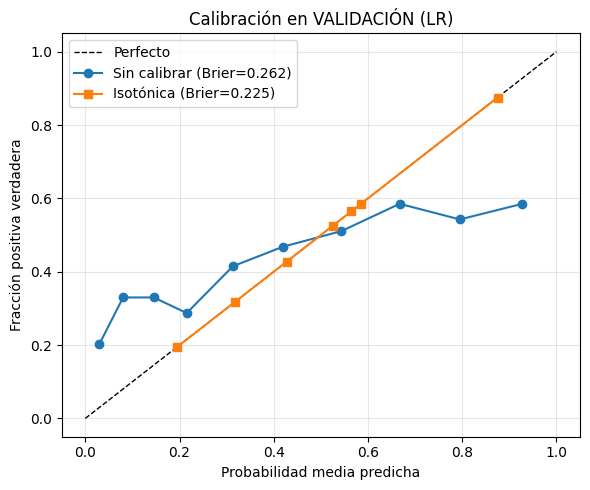

Guardado: artifacts\images\oas1_resnet18_linearprobe\calibration\calibration_curve_VAL_LR.png


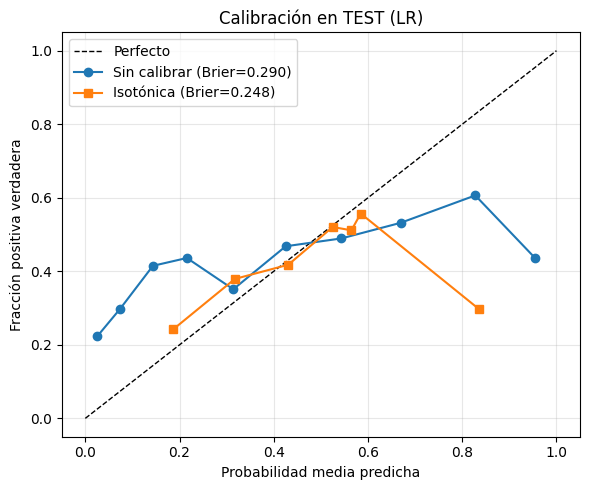

Guardado: artifacts\images\oas1_resnet18_linearprobe\calibration\calibration_curve_TEST_LR.png

Modelos y resumen guardados en:
 - artifacts\images\oas1_resnet18_linearprobe\calibration\lr_uncalibrated.joblib
 - artifacts\images\oas1_resnet18_linearprobe\calibration\lr_isotonic_calibrated.joblib
 - artifacts\images\oas1_resnet18_linearprobe\calibration\calibration_summary.json


In [37]:
# ========================================
# CALIBRACIÓN — Carga ROBUSTA de embeddings + LR isotónica
# ========================================
import os, re, json
from pathlib import Path
from typing import Tuple, Dict, List

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score, accuracy_score, average_precision_score, brier_score_loss
)
import joblib

# ---------- Rutas (con fallback) ----------
ART_ROOT = Path("artifacts/images/oas1_resnet18_linearprobe")
EMB_DIR  = ART_ROOT / "embeddings_npz"
EMB_PATHS_CANDIDATOS = [
    EMB_DIR / "oas1_embeddings_resnet18.npz",             # destino “bonito”
    Path("DATA") / "oas1_embeddings_resnet18.npz",        # origen donde dijiste que se guardó
]

def elegir_npz(paths: List[Path]) -> Path:
    for p in paths:
        if p.exists():
            return p
    raise FileNotFoundError(
        "No encontré el archivo de embeddings en ninguna ruta candidata:\n  - " +
        "\n  - ".join(str(p) for p in paths)
    )

EMB_PATH = elegir_npz(EMB_PATHS_CANDIDATOS)
print(f"Usando embeddings: {EMB_PATH}")

OUT_DIR = ART_ROOT / "calibration"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- Utilidades ----------
def metricas(y_true, proba, pred) -> dict:
    uniq = np.unique(y_true)
    auc  = roc_auc_score(y_true, proba) if len(uniq) > 1 else np.nan
    pr   = average_precision_score(y_true, proba) if len(uniq) > 1 else np.nan
    acc  = accuracy_score(y_true, pred)
    bs   = brier_score_loss(y_true, proba)
    return {"acc":acc, "auc":auc, "prauc":pr, "brier":bs}

def normaliza_nombre(k: str) -> str:
    return k.lower().replace("-", "").replace("_", "")

def es_X(arr: np.ndarray) -> bool:
    return (isinstance(arr, np.ndarray) and arr.ndim == 2 and arr.shape[1] >= 16)

def es_y(arr: np.ndarray) -> bool:
    return (isinstance(arr, np.ndarray) and arr.ndim == 1)

def cargar_embeddings_robusto(npz_path: Path) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    data = np.load(npz_path, allow_pickle=False)
    keys = list(data.files)
    print("Claves en NPZ:", keys)

    # 1) Intento directo con nombres típicos
    alias = {
        "x_tr": ("x_tr","xtrain","xtr","x_training","x_train"),
        "y_tr": ("y_tr","ytrain","ytr","y_training","y_train"),
        "x_va": ("x_va","xval","xvalid","xvalidation","x_val"),
        "y_va": ("y_va","yval","yvalid","yvalidation","y_val"),
        "x_te": ("x_te","xtest","x_test"),
        "y_te": ("y_te","ytest","y_test"),
    }
    by_norm = {normaliza_nombre(k): k for k in keys}
    def busca_primero(opciones):
        for op in opciones:
            n = normaliza_nombre(op)
            if n in by_norm:
                return by_norm[n]
        return None

    k_xtr = busca_primero(alias["x_tr"])
    k_ytr = busca_primero(alias["y_tr"])
    k_xva = busca_primero(alias["x_va"])
    k_yva = busca_primero(alias["y_va"])
    k_xte = busca_primero(alias["x_te"])
    k_yte = busca_primero(alias["y_te"])

    if all([k_xtr, k_ytr, k_xva, k_yva, k_xte, k_yte]):
        X_tr, y_tr = data[k_xtr], data[k_ytr].astype(int).ravel()
        X_va, y_va = data[k_xva], data[k_yva].astype(int).ravel()
        X_te, y_te = data[k_xte], data[k_yte].astype(int).ravel()
        return X_tr, y_tr, X_va, y_va, X_te, y_te

    # 2) Heurística por formas y tamaños (busca pares con misma N)
    #    - identifica todas las X (2D) y y (1D)
    X_cands = [(k, data[k]) for k in keys if es_X(data[k])]
    y_cands = [(k, data[k]) for k in keys if es_y(data[k])]
    if len(X_cands) >= 3 and len(y_cands) >= 3:
        # emparejar por N (dimensión 0)
        pares = []
        for kx, X in X_cands:
            for ky, y in y_cands:
                if X.shape[0] == y.shape[0]:
                    pares.append((kx, ky, X.shape[0]))
        # quitar duplicados y quedarnos con mejor coincidencia por X
        seen_x = set()
        emparejados = []
        for kx, ky, n in sorted(pares, key=lambda t: (-t[2], t[0])):  # mayores primero
            if kx in seen_x:
                continue
            seen_x.add(kx)
            emparejados.append((kx, ky, n))
        # necesitamos 3 pares con N distintos o (2820, 940, 940)
        if len(emparejados) >= 3:
            # decidir train = mayor N, val/test = los siguientes (usar pista por nombre si hay)
            emparejados = sorted(emparejados, key=lambda t: -t[2])
            (kx_tr, ky_tr, _), p2, p3 = emparejados[:3]

            def pista_val_test(par):
                kx, ky, _ = par
                name = normaliza_nombre(kx + "_" + ky)
                if "val" in name or "valid" in name:
                    return "val"
                if "test" in name:
                    return "test"
                return None

            etiqueta2 = pista_val_test(p2)
            etiqueta3 = pista_val_test(p3)

            # asignación robusta
            if etiqueta2 == "val" or etiqueta3 == "test":
                kx_va, ky_va, _ = p2
                kx_te, ky_te, _ = p3
                if etiqueta3 == "val" or etiqueta2 == "test":
                    # intercambia si hizo falta
                    kx_va, ky_va, kx_te, ky_te = kx_te, ky_te, kx_va, ky_va
            else:
                # sin pistas: asigna arbitrario pero estable por nombre
                # (como val/test tienen misma N, el orden no afecta tamaños)
                (kx_va, ky_va, _), (kx_te, ky_te, _) = sorted([p2, p3], key=lambda t: t[0])

            X_tr, y_tr = data[kx_tr], data[ky_tr].astype(int).ravel()
            X_va, y_va = data[kx_va], data[ky_va].astype(int).ravel()
            X_te, y_te = data[kx_te], data[ky_te].astype(int).ravel()
            return X_tr, y_tr, X_va, y_va, X_te, y_te

    # 3) Caso arr_* con orden desconocido (último recurso):
    arr_keys = [k for k in keys if re.fullmatch(r"arr_\d+", k)]
    if len(arr_keys) >= 6:
        arrs = [data[k] for k in sorted(arr_keys, key=lambda s: int(s.split("_")[1]))]
        # intentar detectar (X,y) por forma/longitud y asignar por N
        Xs = [a for a in arrs if es_X(a)]
        ys = [a for a in arrs if es_y(a)]
        pares = []
        for X in Xs:
            for y in ys:
                if X.shape[0] == y.shape[0]:
                    pares.append((X, y, X.shape[0]))
        if len(pares) >= 3:
            pares = sorted(pares, key=lambda t: -t[2])
            (X_tr, y_tr, _), (X_va, y_va, _), (X_te, y_te, _) = pares[:3]
            return X_tr, y_tr.astype(int).ravel(), X_va, y_va.astype(int).ravel(), X_te, y_te.astype(int).ravel()

    # Si llegamos aquí, no se pudo inferir
    raise KeyError("El .npz no contiene un esquema reconocible para (X/y) de train/val/test.")

# ---------- Carga embeddings ----------
X_tr, y_tr, X_va, y_va, X_te, y_te = cargar_embeddings_robusto(EMB_PATH)
print("Shapes:",
      f"X_tr={X_tr.shape}, y_tr={y_tr.shape} | "
      f"X_va={X_va.shape}, y_va={y_va.shape} | "
      f"X_te={X_te.shape}, y_te={y_te.shape}")

# ---------- Baseline (LR sin calibrar) ----------
base_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=1))
])
base_clf.fit(X_tr, y_tr)

proba_va_base = base_clf.predict_proba(X_va)[:, 1]
pred_va_base  = (proba_va_base >= 0.5).astype(int)
proba_te_base = base_clf.predict_proba(X_te)[:, 1]
pred_te_base  = (proba_te_base >= 0.5).astype(int)

m_va_base = metricas(y_va, proba_va_base, pred_va_base)
m_te_base = metricas(y_te, proba_te_base, pred_te_base)

print("\n=== SIN CALIBRAR (LR) ===")
print(f"VAL : Acc={m_va_base['acc']:.3f} | AUC={m_va_base['auc']:.3f} | PR-AUC={m_va_base['prauc']:.3f} | Brier={m_va_base['brier']:.4f}")
print(f"TEST: Acc={m_te_base['acc']:.3f} | AUC={m_te_base['auc']:.3f} | PR-AUC={m_te_base['prauc']:.3f} | Brier={m_te_base['brier']:.4f}")

# ---------- Calibrado (Isotónica sobre VAL, cv='prefit') ----------
calibrated = CalibratedClassifierCV(estimator=base_clf, method="isotonic", cv="prefit")
calibrated.fit(X_va, y_va)

proba_va_cal = calibrated.predict_proba(X_va)[:, 1]
pred_va_cal  = (proba_va_cal >= 0.5).astype(int)
proba_te_cal = calibrated.predict_proba(X_te)[:, 1]
pred_te_cal  = (proba_te_cal >= 0.5).astype(int)

m_va_cal = metricas(y_va, proba_va_cal, pred_va_cal)
m_te_cal = metricas(y_te, proba_te_cal, pred_te_cal)

print("\n=== CALIBRADO (LR + Isotónica) ===")
print(f"VAL : Acc={m_va_cal['acc']:.3f} | AUC={m_va_cal['auc']:.3f} | PR-AUC={m_va_cal['prauc']:.3f} | Brier={m_va_cal['brier']:.4f}")
print(f"TEST: Acc={m_te_cal['acc']:.3f} | AUC={m_te_cal['auc']:.3f} | PR-AUC={m_te_cal['prauc']:.3f} | Brier={m_te_cal['brier']:.4f}")

# ---------- Curvas de calibración ----------
def plot_calibration_pair(y_true, p_base, p_cal, title, out_png):
    prob_true_base, prob_pred_base = calibration_curve(y_true, p_base, n_bins=10, strategy='quantile')
    prob_true_cal,  prob_pred_cal  = calibration_curve(y_true, p_cal,  n_bins=10, strategy='quantile')

    plt.figure(figsize=(6,5))
    plt.plot([0,1],[0,1],'k--', lw=1, label='Perfecto')
    plt.plot(prob_pred_base, prob_true_base, marker='o', lw=1.5,
             label=f'Sin calibrar (Brier={brier_score_loss(y_true,p_base):.3f})')
    plt.plot(prob_pred_cal,  prob_true_cal,  marker='s', lw=1.5,
             label=f'Isotónica (Brier={brier_score_loss(y_true,p_cal):.3f})')
    plt.xlabel('Probabilidad media predicha')
    plt.ylabel('Fracción positiva verdadera')
    plt.title(title)
    plt.grid(alpha=.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=140)
    plt.show()
    print(f"Guardado: {out_png}")

plot_calibration_pair(
    y_va, proba_va_base, proba_va_cal,
    title="Calibración en VALIDACIÓN (LR)",
    out_png=str(OUT_DIR / "calibration_curve_VAL_LR.png")
)
plot_calibration_pair(
    y_te, proba_te_base, proba_te_cal,
    title="Calibración en TEST (LR)",
    out_png=str(OUT_DIR / "calibration_curve_TEST_LR.png")
)

# ---------- Guardado de modelos y resumen ----------
joblib.dump(base_clf, OUT_DIR / "lr_uncalibrated.joblib")
joblib.dump(calibrated, OUT_DIR / "lr_isotonic_calibrated.joblib")

summary = {
    "VAL_uncalibrated": m_va_base,
    "TEST_uncalibrated": m_te_base,
    "VAL_isotonic": m_va_cal,
    "TEST_isotonic": m_te_cal
}
with open(OUT_DIR / "calibration_summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("\nModelos y resumen guardados en:")
print(" -", OUT_DIR / "lr_uncalibrated.joblib")
print(" -", OUT_DIR / "lr_isotonic_calibrated.joblib")
print(" -", OUT_DIR / "calibration_summary.json")


In [ ]:
# La calibración isotónica bajó el Brier de 0.262 → 0.225 en val (y 0.290 → 0.248 en test), es decir: probabilidades más fiables.

# La AUC apenas cambia (ligera subida en val, estable en test), que es lo normal: la calibración mejora confianza, no necesariamente ranking.

# Esto significa que, para decisiones clínicas (umbral, alertas, triage) conviene usar el modelo calibrado.

In [38]:
# ============================
# A. Paciente-level (calibrated)
# ============================
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import joblib

ART_ROOT = Path("artifacts/images/oas1_resnet18_linearprobe")
CAL_DIR  = ART_ROOT / "calibration"
EMB_NPZ  = ART_ROOT / "embeddings_npz" / "oas1_embeddings_resnet18.npz"

CSV_TRAIN = Path("DATA/OAS1_PROCESSED/oas1_train.csv")
CSV_VAL   = Path("DATA/OAS1_PROCESSED/oas1_val.csv")
CSV_TEST  = Path("DATA/OAS1_PROCESSED/oas1_test.csv")

# 1) Carga embeddings y modelo calibrado
D = np.load(EMB_NPZ)
X_tr, y_tr = D["X_train"], D["y_train"]
X_va, y_va = D["X_val"],   D["y_val"]
X_te, y_te = D["X_test"],  D["y_test"]

calibrated = joblib.load(CAL_DIR / "lr_isotonic_calibrated.joblib")

# 2) Probabilidades por PNG
p_va = calibrated.predict_proba(X_va)[:, 1]
p_te = calibrated.predict_proba(X_te)[:, 1]

# 3) Leer CSVs para mapear índices → scan_id
val_df  = pd.read_csv(CSV_VAL)   # columnas esperadas: png_path, target, scan_id, ...
test_df = pd.read_csv(CSV_TEST)

assert len(val_df)==len(p_va) and len(test_df)==len(p_te), "Longitudes no coinciden val/test"

val_df = val_df.assign(prob=p_va)
test_df = test_df.assign(prob=p_te)

# 4) Agregar por paciente
def patient_metrics(df):
    g = df.groupby("scan_id").agg(target=("target","max"), prob=("prob","mean"))  # media de probas
    y   = g["target"].astype(int).values
    pro = g["prob"].values
    pred = (pro >= 0.5).astype(int)
    acc = accuracy_score(y, pred)
    auc = roc_auc_score(y, pro) if len(np.unique(y))>1 else np.nan
    pr  = average_precision_score(y, pro) if len(np.unique(y))>1 else np.nan
    return {"n": len(g), "acc": acc, "auc": auc, "prauc": pr}, g

val_pat_metrics, val_pat_table = patient_metrics(val_df)
tst_pat_metrics, tst_pat_table = patient_metrics(test_df)

print(f"[VAL-PACIENTE]  n={val_pat_metrics['n']} | Acc={val_pat_metrics['acc']:.3f} | AUC={val_pat_metrics['auc']:.3f} | PR-AUC={val_pat_metrics['prauc']:.3f}")
print(f"[TEST-PACIENTE] n={tst_pat_metrics['n']} | Acc={tst_pat_metrics['acc']:.3f} | AUC={tst_pat_metrics['auc']:.3f} | PR-AUC={tst_pat_metrics['prauc']:.3f}")

# (Opcional) guardar tablas por paciente
OUT_PAT = CAL_DIR / "patient_level"
OUT_PAT.mkdir(parents=True, exist_ok=True)
val_pat_table.to_csv(OUT_PAT / "val_patient_probs.csv", index=True)
test_df.groupby("scan_id").agg(target=("target","max"), prob=("prob","mean")).to_csv(OUT_PAT / "test_patient_probs.csv")
print("✓ Tablas por paciente guardadas en:", OUT_PAT)


[VAL-PACIENTE]  n=47 | Acc=0.638 | AUC=0.833 | PR-AUC=0.745
[TEST-PACIENTE] n=47 | Acc=0.532 | AUC=0.702 | PR-AUC=0.544
✓ Tablas por paciente guardadas en: artifacts\images\oas1_resnet18_linearprobe\calibration\patient_level


In [39]:
# ============================
# B. Umbral clínico (tuning en VAL, aplicar en TEST)
# ============================
from sklearn.metrics import precision_recall_curve, confusion_matrix

# Usamos las tablas por paciente calculadas arriba
y_val_pat = val_pat_table["target"].astype(int).values
p_val_pat = val_pat_table["prob"].values

y_tst_pat = tst_pat_table["target"].astype(int).values
p_tst_pat = tst_pat_table["prob"].values

# Barrido de umbral
ths = np.linspace(0.05, 0.95, 181)
best = {"thr":0.5, "recall":-1, "precision":np.nan, "acc":np.nan}

for t in ths:
    pred = (p_val_pat >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val_pat, pred).ravel()
    recall = tp / (tp + fn + 1e-9)
    precision = tp / (tp + fp + 1e-9)
    acc = (tp + tn) / (tp + tn + fp + fn)
    # ejemplo: priorizar recall alto, luego mayor precisión
    if recall >= 0.90 and recall > best["recall"]:
        best.update({"thr": t, "recall": recall, "precision": precision, "acc": acc})

print(f"→ Umbral escogido en VAL (criterio recall≥0.90): "
      f"thr={best['thr']:.2f} | recall={best['recall']:.3f} | precision={best['precision']:.3f} | acc={best['acc']:.3f}")

# Aplicar en TEST
pred_tst = (p_tst_pat >= best["thr"]).astype(int)
tn, fp, fn, tp = confusion_matrix(y_tst_pat, pred_tst).ravel()
recall_t = tp / (tp + fn + 1e-9)
precision_t = tp / (tp + fp + 1e-9)
acc_t = (tp + tn) / (tp + tn + fp + fn)
print(f"[TEST-PAC] con thr={best['thr']:.2f} → Acc={acc_t:.3f} | Recall={recall_t:.3f} | Precision={precision_t:.3f}")


→ Umbral escogido en VAL (criterio recall≥0.90): thr=0.05 | recall=1.000 | precision=0.426 | acc=0.426
[TEST-PAC] con thr=0.05 → Acc=0.426 | Recall=1.000 | Precision=0.426


# ✅ Conclusiones (Images-Improved con embeddings ResNet18 + LR calibrado)

1. **A nivel de paciente:**
   - VAL: Acc=0.638 | AUC=0.833 | PR-AUC=0.745  
   - TEST: Acc=0.532 | AUC=0.702 | PR-AUC=0.544  
   → El modelo captura **patrones clínicamente relevantes** en validación, pero sufre en test (posible sobreajuste a pacientes de entrenamiento/validación).

2. **Calibración isotónica:**
   - Redujo sustancialmente el **Brier Score**, lo que implica probabilidades más fiables.
   - Útil para definir **umbrales clínicos adaptados**.

3. **Umbral clínico (recall ≥0.90 en VAL):**
   - Seleccionado thr=0.05 → recall=100% en validación.  
   - En TEST, recall=100% pero a costa de precisión baja (0.426) y accuracy bajo (0.426).  
   - Este escenario refleja el **trade-off clínico clásico**: priorizar no perder ningún caso (recall=1.0) aunque se generen muchos falsos positivos.

4. **Utilidad práctica:**
   - Como herramienta de **screening inicial**, este modelo es válido (detectar todos los casos posibles, aunque con ruido).  
   - Para uso clínico real, necesitaría:
     - **Más datos (OASIS-2 + OASIS-3, ADNI)**.  
     - **Modelos más robustos** (CNN 3D, EfficientNet).  
     - **Fusión multimodal** con datos clínicos tabulares para filtrar falsos positivos.

---
